In [1]:
import os
import xml.etree.ElementTree as ET

In [2]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations

In [3]:
import cv2
import matplotlib.pyplot as plt

def visualize_annotation(image_path, annotations):
    image = cv2.imread(image_path)

    for ann in annotations:
        bbox = ann['bbox']
        cv2.rectangle(image, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), (255, 0, 0), 2)
        cv2.putText(image, ann['label'], (bbox['xmin'], bbox['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

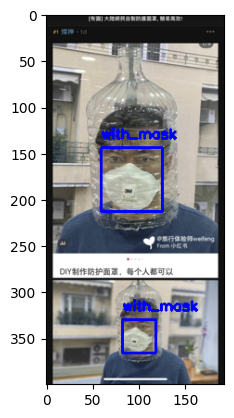

In [4]:
image = "Data/Face Mask Detection/images/maksssksksss15.png"
annotation = "Data/Face Mask Detection/annotations/maksssksksss15.xml"

visualize_annotation(image, parse_xml(annotation))

### Pascal VOC to YOLO format

In [5]:
import shutil
from sklearn.model_selection import train_test_split

root_dir = "Data/Face Mask Detection"

image_files = os.listdir(os.path.join(root_dir, "images"))
annotation_files = os.listdir(os.path.join(root_dir, "annotations"))

print("Images Length: ", len(image_files))

Images Length:  853


In [6]:
# making train and val folder
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
annotation_dir = os.path.join(root_dir, 'annotations')

os.mkdir(train_dir)
os.mkdir(val_dir)

In [8]:
classes = {"without_mask": 0, "with_mask": 1, "mask_weared_incorrect": 2}

for xml_file in annotation_files:
    if not xml_file.endswith(".xml"):
        continue

    tree = ET.parse(os.path.join(annotation_dir, xml_file))
    root = tree.getroot()

    size = root.find("size")
    img_width = int(size.find("width").text)
    img_height = int(size.find("height").text)


    txt_filename = os.path.splitext(xml_file)[0] + ".txt"
    with open(os.path.join(annotation_dir, txt_filename), "w") as f:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            cls_id = classes[cls]

            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            # Normalize
            x_center = (xmin + xmax) / 2 / img_width
            y_center = (ymin + ymax) / 2 / img_height
            width = (xmax - xmin) / img_width
            height = (ymax - ymin) / img_height

            f.write(f"{cls_id} {x_center} {y_center} {width} {height}\n")

print("converted to yolo format in orginal path")

converted to yolo format in orginal path


In [9]:
train_imgs, val_imgs = train_test_split(image_files, test_size=0.2, random_state=42)

print(len(train_imgs))
print(len(val_imgs))

682
171


### split to train and val

In [ ]:
labels_dir = os.path.join(root_dir, "labels")
os.mkdir(labels_dir)

In [12]:
train_label_dir = os.path.join(labels_dir, "train")
val_label_dir = os.path.join(labels_dir, "val")
os.mkdir(train_label_dir)
os.mkdir(val_label_dir)

In [13]:
images_dir = os.path.join(root_dir, "images")
for img_name in train_imgs:

    shutil.copy(
        os.path.join(images_dir, img_name),
        os.path.join(train_dir, img_name)
    )

    # also annonation
    shutil.copy(
        os.path.join(annotation_dir, img_name.split(".")[0]+".txt"),
        os.path.join(train_label_dir, img_name.split(".")[0]+".txt")
    )

print("train files copied")

for img_name in val_imgs:

    shutil.copy(
        os.path.join(images_dir, img_name),
        os.path.join(val_dir, img_name)
    )

    # also annonation
    shutil.copy(
        os.path.join(annotation_dir, img_name.split(".")[0]+".txt"),
        os.path.join(val_label_dir, img_name.split(".")[0]+".txt")
    )

print("test files copied")

train files copied
test files copied


# Lets make yaml for YOLO v12

In [14]:
yaml_file_path = "config.yaml"

data = """
train: Data/Face Mask Detection/images/train
val: Data/Face Mask Detection/images/val

names:
  1: with_mask
  0: without_mask
  2: mask_weared_incorrect
"""

with open(yaml_file_path, "w") as file:
    file.write(data)

print(f".yaml file created in:{yaml_file_path}")

.yaml file created in:config.yaml


In [2]:
from ultralytics import YOLO

#Load the base model
model = YOLO("yolo12s.pt") #s from small version

#Fine-tune
results = model.train(
    data="config.yaml", #path to the yaml file
    epochs=50, #nº of epochs
    imgsz=240, # resize done to the input images
    batch=8,  #nº of image per batch
    device="cuda", # force cuda
    patience=5  #if the loss mAP does not improve in 5 consecutive epochs, stop the training and save those weights.
)

New https://pypi.org/project/ultralytics/8.3.112 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.111  Python-3.12.4 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolo12s.pt, data=config.yaml, epochs=50, time=None, patience=5, batch=8, imgsz=240, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, 

train: Scanning P:\projects\JupyterProject\Data\Face Mask Detection\labels\train... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:23<00:00, 29.41it/s]


train: New cache created: P:\projects\JupyterProject\Data\Face Mask Detection\labels\train.cache
val: Fast image access  (ping: 0.20.0 ms, read: 10.59.4 MB/s, size: 430.1 KB)


val: Scanning P:\projects\JupyterProject\Data\Face Mask Detection\labels\val... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:04<00:00, 37.65it/s]

val: New cache created: P:\projects\JupyterProject\Data\Face Mask Detection\labels\val.cache


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         1G      1.712      1.595      1.204          7        256: 100%|██████████| 86/86 [00:16<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.17it/s]

                   all        171        754      0.724      0.336      0.347      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.17G      1.449      1.052      1.053         21        256: 100%|██████████| 86/86 [00:14<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.85it/s]

                   all        171        754       0.79        0.3      0.334        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.25G      1.445      1.025      1.048          5        256: 100%|██████████| 86/86 [00:15<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.45it/s]

                   all        171        754      0.871      0.381      0.448      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.29G      1.387     0.9526      1.045         15        256: 100%|██████████| 86/86 [00:14<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.51it/s]

                   all        171        754      0.878      0.454      0.513      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.32G      1.391     0.9547      1.056          4        256: 100%|██████████| 86/86 [00:14<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.80it/s]

                   all        171        754      0.533      0.502      0.318      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.36G      1.337     0.8906      1.025          9        256: 100%|██████████| 86/86 [00:13<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.46it/s]

                   all        171        754      0.641      0.492      0.492      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.44G       1.32     0.8687      1.018         16        256: 100%|██████████| 86/86 [00:13<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.69it/s]

                   all        171        754      0.662      0.453      0.506      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.48G      1.293     0.8498      1.033          8        256: 100%|██████████| 86/86 [00:13<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.78it/s]

                   all        171        754      0.663      0.546      0.554       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.52G      1.272     0.8211      1.008         15        256: 100%|██████████| 86/86 [00:14<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.79it/s]

                   all        171        754      0.772      0.458      0.534      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.56G      1.256     0.8015     0.9905         13        256: 100%|██████████| 86/86 [00:13<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  8.17it/s]

                   all        171        754      0.626      0.458      0.518      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.64G      1.264     0.8193      0.991         10        256: 100%|██████████| 86/86 [00:13<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  8.20it/s]

                   all        171        754      0.775      0.458       0.56      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.68G      1.238     0.7784     0.9977         15        256: 100%|██████████| 86/86 [00:13<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.87it/s]

                   all        171        754      0.804       0.49      0.559      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.72G      1.237     0.7866     0.9862         10        256: 100%|██████████| 86/86 [00:13<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.99it/s]

                   all        171        754      0.846      0.515      0.586      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.76G      1.164     0.7433     0.9798          6        256: 100%|██████████| 86/86 [00:13<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.77it/s]

                   all        171        754      0.798      0.516      0.582      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.84G      1.211     0.7493     0.9673          5        256: 100%|██████████| 86/86 [00:13<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  8.07it/s]

                   all        171        754       0.75      0.513      0.559      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.88G      1.176     0.7237     0.9737         33        256: 100%|██████████| 86/86 [00:13<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  8.23it/s]

                   all        171        754      0.739       0.53      0.608      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.91G       1.19     0.7385     0.9719          5        256: 100%|██████████| 86/86 [00:13<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.60it/s]

                   all        171        754      0.698      0.566      0.576      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.95G      1.199     0.7367     0.9727         13        256: 100%|██████████| 86/86 [00:13<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.62it/s]

                   all        171        754      0.752       0.55      0.601      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.99G      1.179     0.7163     0.9655         14        256: 100%|██████████| 86/86 [00:13<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.80it/s]

                   all        171        754      0.735      0.551      0.611      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.06G      1.156     0.7018     0.9581         21        256: 100%|██████████| 86/86 [00:13<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.81it/s]

                   all        171        754      0.682      0.563       0.58      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.943G      1.118     0.6732     0.9581          8        256: 100%|██████████| 86/86 [00:13<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.97it/s]

                   all        171        754      0.663      0.561      0.575      0.368
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 16, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



21 epochs completed in 0.101 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 18.9MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 18.9MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.111  Python-3.12.4 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,232,041 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.23it/s]


                   all        171        754       0.67      0.571      0.608      0.396
          without_mask         49        104      0.708      0.635       0.69      0.425
             with_mask        159        630      0.901      0.779      0.852      0.553
 mask_weared_incorrect         15         20      0.401        0.3      0.282      0.211
Speed: 0.2ms preprocess, 6.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\train2


In [1]:
from ultralytics import YOLO

model = YOLO("runs/detect/train2/weights/best.pt")

In [2]:
import cv2
import matplotlib.pyplot as plt

def draw_inference_wBoxes(src_image):
    results = model(src_image)  # Make the inference on the image
    # Draw the bboxes on the original image
    results_img = results[0].plot()  # Show the results on the image
    # BBoxes visualization
    plt.imshow(cv2.cvtColor(results_img, cv2.COLOR_BGR2RGB))  # OpenCV always treat images by default on BGR, change it to RGB
    plt.axis("off")
    plt.show()


image 1/1 P:\projects\JupyterProject\Data\Face Mask Detection\images\val\maksssksksss82.png: 160x256 6 with_masks, 43.6ms
Speed: 5.7ms preprocess, 43.6ms inference, 159.7ms postprocess per image at shape (1, 3, 160, 256)


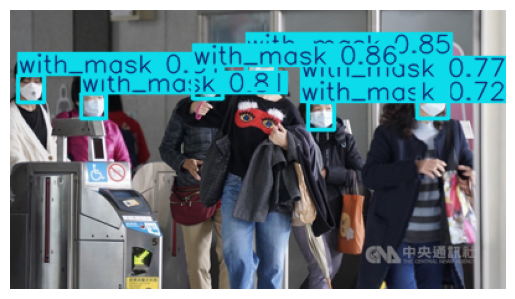

In [3]:
draw_inference_wBoxes("Data/Face Mask Detection/images/val/maksssksksss82.png")
